In [1]:
from qdrant_client import QdrantClient, models

from typing import TypedDict, List, Annotated
import functools
import operator
from pydantic import BaseModel, Field

import torch
from transformers import AutoModel
from FlagEmbedding import BGEM3FlagModel

from RAGModule.retrieve import retrieve_relevant_chunks
from RAGModule.utils import format_chunks

from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool

from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


from dotenv import load_dotenv
load_dotenv()

torch.set_grad_enabled(False)

/home/taiquach123471/anaconda3/envs/insomnia_chatbot_v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = QdrantClient("http://localhost:6333")
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0)
bge_m3 = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)
jina_v3 = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True).to('cuda')

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 49912.38it/s]
/home/taiquach123471/anaconda3/envs/insomnia_chatbot_v2/lib/python3.11/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue

In [3]:
retrieve_relevant_chunks = functools.partial(retrieve_relevant_chunks, jina_embedding = jina_v3, bge_embedding = bge_m3, client = client)

In [4]:
class RewriterResponse(BaseModel):
    """Response from the rewriter - a LLM that rewrites the user's query based on provided context (chat history)"""
    response: str = Field(description="The rewritten query or a request for clarification (if the user's query is unclear)")
    need_clarification: bool = Field(description="Indicates if the rewriter requires clarification from the user to effectively rewrite the user's query.")

class QueryAnalysis(BaseModel):
    """Analyzes a query and context to determine the next action for a LLM."""
    route: str = Field(description="Action route based on query analysis. 'answer' if the query and context are sufficient for a direct response, 'retrieve' if additional information is needed from a vector store.")

class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    rewriter_response: RewriterResponse
    query_analysis: QueryAnalysis
    documents: list

In [5]:
query_analyzer_system_prompt = """You are an intelligent assistant responsible for analyzing a given chat history (context) and a user's query to determine the appropriate action. Based on your analysis:
Respond with 'answer' if the context is sufficient to address the query.
Respond with 'retrieve' if additional information is needed."""

query_analyzer_prompt = ChatPromptTemplate.from_messages([
    ("system", query_analyzer_system_prompt),
    MessagesPlaceholder(variable_name="messages")
])

query_analyzer_chain = query_analyzer_prompt | llm.with_structured_output(QueryAnalysis)

In [6]:
rewriter_system_prompt = """You are an assistant specialized in rewriting queries for optimized information retrieval. Your primary responsibilities are:
1. Convert the user's latest query, along with relevant history (if possible), into a standalone query that accurately reflects the user's intent and provides sufficient context for retrieval from a vector database. This query can be decomposed into simpler sub-queries if the original query is complex.
2. If the latest query is already clear and complete, make no changes.
3. If the latest query and chat history cannot be used to form a coherent or complete query (e.g., no chat history and the user's query is ambiguous), gently request clarification from the user. Kindly ask: "Could you please provide more details about [specific aspect of the query]?"
Output only the rewritten query or the request for clarification. Do not explain or answer the query.
"""

rewriter_prompt = ChatPromptTemplate.from_messages([
    ("system", rewriter_system_prompt),
    MessagesPlaceholder(variable_name="messages"),
])

rewriter_chain = rewriter_prompt | llm.with_structured_output(RewriterResponse)

In [7]:
system_prompt = """You are an AI chatbot designed to answer questions about insomnia using context retrieved from scientific articles and previous chat history. Your goal is to provide clear, evidence-based responses and practical advice to help users. Following those instructions:

1. Use the information provided within the <context> tags regarding insomnia whenever available.
2. If no <context> is provided but the chat history provides sufficient information to address the user's query, use the chat history.
3. If a question is unclear or needs more context, ask the user for clarification.

<context>
{context}
</context>
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder("messages"),
])

response_llm = prompt | llm

In [8]:
def query_analyzer(state: State):
    query_analyzer_response: QueryAnalysis = query_analyzer_chain.invoke({"messages": state["messages"]})
    return {"query_analysis": query_analyzer_response}

def rewriter(state: State):
    rewriter_response: RewriterResponse = rewriter_chain.invoke({"messages": state["messages"]})
    if rewriter_response.need_clarification:
        return {"rewriter_response": rewriter_response, "messages": [AIMessage(rewriter_response.response)]}
    return {"rewriter_response": rewriter_response}

def generate_response(state: State):
    response =response_llm.invoke(input={"messages": state['messages'], "context": format_chunks(state['documents'])})
    return {"messages": [response]}

def ask_human(state: State):
    pass

def query_analyzer_route(state: State):
    if state["query_analysis"].route == "retrieve":
        return "rewriter"
    return "responder"

def rewriter_route(state: State):
    if state["rewriter_response"].need_clarification:
        return "ask_human"
    return "retrieve"

def retrieve_from_vectorstore(state: State):
    relevant_chunks = retrieve_relevant_chunks(state['rewriter_response'].response)
    return {"documents": relevant_chunks}

In [9]:
graph_builder = StateGraph(State)

graph_builder.add_node("query_analyzer", query_analyzer)
graph_builder.add_node("rewriter", rewriter)
graph_builder.add_node("ask_human", ask_human)
graph_builder.add_node("responder", generate_response)
graph_builder.add_node("retrieve", retrieve_from_vectorstore)

graph_builder.add_edge(START, "query_analyzer")
graph_builder.add_conditional_edges("rewriter", rewriter_route, {"ask_human": "ask_human", "retrieve": "retrieve"})
graph_builder.add_conditional_edges("query_analyzer", query_analyzer_route, {"rewriter": "rewriter", "responder": "responder"})
graph_builder.add_edge("ask_human", "rewriter")
graph_builder.add_edge("retrieve", "responder")


In [10]:
graph = graph_builder.compile(checkpointer=MemorySaver(), interrupt_before=["ask_human"])

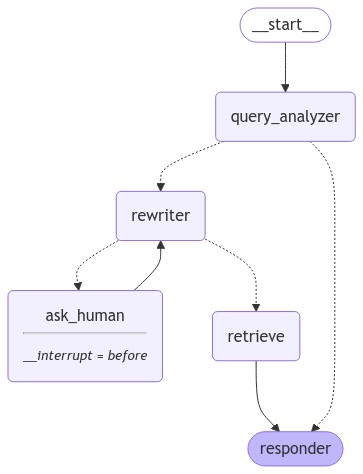

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
config = {"configurable": {"thread_id": "20"}}

In [33]:
is_first = True
while True:
    query = input()
    HumanMessage(query).pretty_print()

    if query == "q":
        break

    try:
        if graph.get_state(config).next[0] == 'ask_human':
            is_first = False
            graph.update_state(config, {"messages": [HumanMessage(content = query)]}, as_node="ask_human")
    except:
        pass
        
        
    
    for event in graph.stream({"messages": [HumanMessage(content = query)]} if is_first else None, config=config, stream_mode="values"):
        pass
    
    print(graph.get_state(config).values['messages'][-1].pretty_print())


================================ Human Message =================================

How caffeine can affect my health
================================== Ai Message ==================================

Caffeine can have both positive and negative effects on your health, depending on the amount consumed and individual sensitivity. Based on the provided context, here are some potential effects of caffeine on your health:

**Negative effects:**

1. **Sleep disturbances**: Caffeine can interfere with sleep patterns, leading to insomnia, daytime sleepiness, and other sleep-related problems.
2. **Anxiety and nervousness**: High levels of caffeine can cause feelings of anxiety, jitteriness, and an increased heart rate.
3. **Increased heart rate and blood pressure**: Caffeine can increase heart rate and blood pressure, which may be problematic for people with pre-existing heart conditions.
4. **Dehydration**: Caffeine is a diuretic, which means that it can lead to dehydration if not balanced with 